In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
import skimage.io as io

# Plot compare

In [2]:
os.getcwd()

'/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src'

In [3]:
# load pngs:
clevr_comps = io.imread('videos/clevr_comet_reconstructed_best.png')
clevr_gifs = io.imread('videos/clevr_comet_best.gif')
our_clevr_comps = io.imread('videos/Clevr_reconstructed_our_code.png')
our_clevr_gifs = io.imread('videos/Clevr_our_code.gif')

(64, 64, 3)
(64, 64, 3)


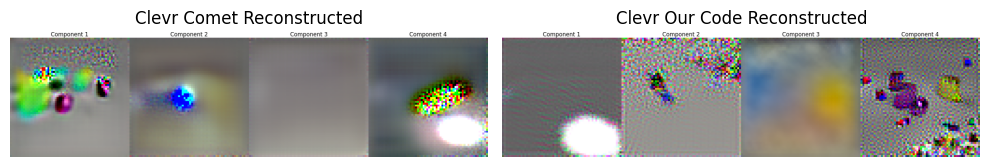

In [21]:
clevr_gifs = clevr_gifs[-1]
our_clevr_gifs = our_clevr_gifs[-1]
print(clevr_gifs.shape)
print(our_clevr_gifs.shape)


# crop all the white space around comps:
def crop_image(image):
    # Convert to grayscale
    gray = np.mean(image, axis=2)
    
    # Find the non-white pixels
    mask = gray < 255
    
    # Get the bounding box of the non-white pixels
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    # Crop the image
    return image[np.ix_(rows, cols)]
clevr_comps_cropped = crop_image(clevr_comps)
our_clevr_comps_cropped = crop_image(our_clevr_comps)
# Plot the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(clevr_comps_cropped)
plt.title('Clevr Comet Reconstructed')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(our_clevr_comps_cropped)
plt.title('Clevr Our Code Reconstructed')
plt.axis('off')
plt.tight_layout()
plt.show()

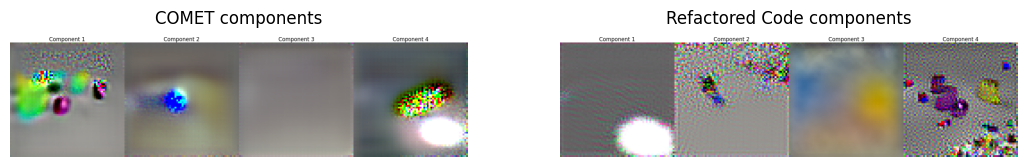

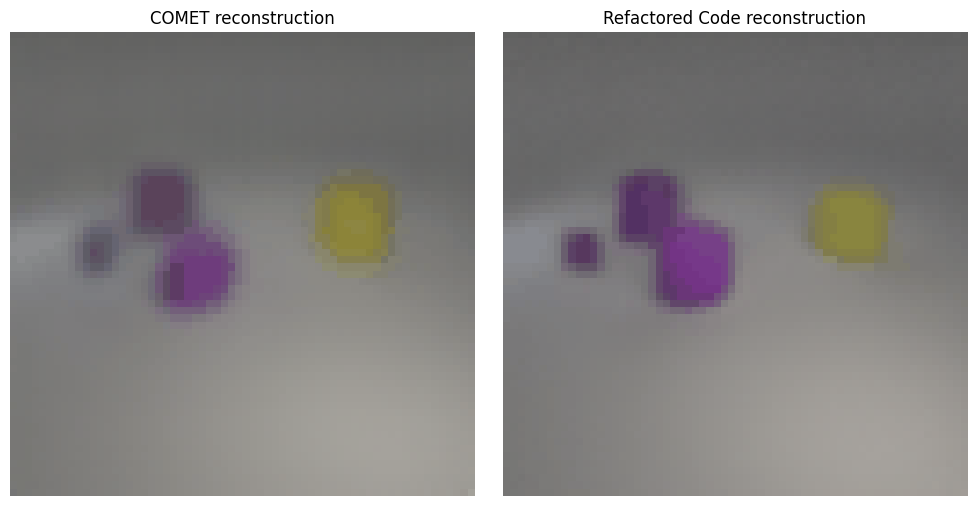

In [ ]:
# Plot components comparison
fig_comp, axs_comp = plt.subplots(1, 2, figsize=(13, 13))
axs_comp[0].imshow(clevr_comps_cropped)
axs_comp[0].set_title('COMET components', pad=10)
axs_comp[0].axis('off')
axs_comp[1].imshow(our_clevr_comps_cropped)
axs_comp[1].set_title('Refactored Code components', pad=10)
axs_comp[1].axis('off')
plt.savefig('videos/compare_clevr_components.png', dpi=300, bbox_inches='tight')
plt.show()


original_image = 

# Plot reconstruction comparison
fig_recon, axs_recon = plt.subplots(1, 2, figsize=(10, 5))
axs_recon[0].imshow(clevr_gifs)
axs_recon[0].set_title('COMET reconstruction')
axs_recon[0].axis('off')
axs_recon[1].imshow(our_clevr_gifs)
axs_recon[1].set_title('Refactored Code reconstruction')
axs_recon[1].axis('off')
plt.tight_layout()
plt.savefig('videos/compare_clevr_reconstruction.png', dpi=300)
plt.show()

# Load models and compare loss statistically

In [1]:
import os
os.getcwd() 
os.chdir(os.pardir)
os.getcwd()

'/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning'

In [10]:
import matplotlib.pyplot as plt
import torch
from src.comet_models import LatentEBM, LatentEBM128
from src.config.load_config import load_config
from src.dataloader import MRI2D, Clevr
import matplotlib.pyplot as plt
from imageio.v2 import get_writer
import logging
from tqdm import tqdm
from easydict import EasyDict
from src.test_comet_model import gen_image

In [12]:
# Load a good comet model
ckpt = torch.load('/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/models/clevr_comet_99900.pth.pth', torch.device('cpu'))
config = EasyDict(ckpt['FLAGS'])

dataset = Clevr(config, train=False)
state_dicts = ckpt['model_state_dict_0']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LatentEBM(config, 'clevr').to(device)

model.load_state_dict(state_dicts, strict=False)
models = [model for i in range(4)]

tensor_img = dataset.__getitem__(0)[0].unsqueeze(0).expand(-1, 3, -1, -1)
print(f"Input tensor shape: {tensor_img.shape}")

latent = models[0].embed_latent(tensor_img)
latents = torch.chunk(latent, config.components, dim=1)
im_neg = torch.rand_like(tensor_img)
im_negs_comet = gen_image(latents, config, models, im_neg, 120)

im = tensor_img

comet_final_image = im_negs_comet[-1]

Input tensor shape: torch.Size([1, 3, 64, 64])


100%|██████████| 120/120 [00:13<00:00,  8.64it/s]


In [4]:
# now get our model:
import matplotlib.pyplot as plt
import torch
from src.comet_models import LatentEBM, LatentEBM128
from src.config.load_config import load_config
from src.dataloader import MRI2D, Clevr
from imageio.v2 import get_writer
import logging
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from src.test_final import gen_image as gen_image_our

    # 2DMRI our model our data:
config_path = '/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/config/clevr_config.yml'
dataset_type = 'Clevr'
model_type = 'LatentEBM128'
checkpoint_path = '/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/models/clevr_on_ourde_code_models_51800.pth'

run_name = checkpoint_path.split("/")[-1].split(".")[0]
logging.info(f"Run name: {run_name}")
# Load configuration
config = load_config(config_path)
logging.info(f"Loaded config: {config}")

run_name = checkpoint_path.split("/")[-1].split(".")[0]
logging.info(f"Run name: {run_name}")

# Initialize dataset
if dataset_type == "MRI2D":
    dataset = MRI2D(config)
elif dataset_type == "Clevr":
    dataset = Clevr(config, train=False)
else:
    raise ValueError(f"Unsupported dataset type: {dataset_type}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
if model_type == "LatentEBM":
    model_class = LatentEBM
elif model_type == "LatentEBM128":
    model_class = LatentEBM128
else:
    raise ValueError(f"Unsupported model type: {model_type}")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
state_dicts = checkpoint if isinstance(checkpoint, list) else [checkpoint]
models = [model_class(config, dataset_type).to(device) for _ in range(len(state_dicts))]
for i, model in enumerate(models):
    model.load_state_dict(state_dicts[i], strict=False)
    model.eval()  # Set to evaluation mode




In [5]:
# Prepare data
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=config.data_workers)
im, idx = next(iter(dataloader))
im = im.to(device)

# Embed latent
latent = models[0].embed_latent(im)
latents = torch.chunk(latent, config.components, dim=1)
# each latent is a component, and has size (batch_size, latent_dim)

im_neg = torch.rand_like(im)
im_negs = gen_image_our(latents, config, models, im_neg, 30)

100%|██████████| 30/30 [02:12<00:00,  4.41s/it]


(64, 64, 3)


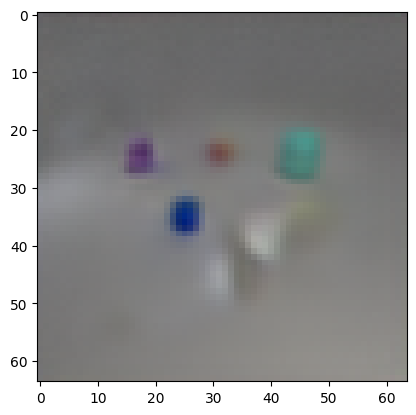

In [8]:
our_final_image = im_negs[-1][0].detach().cpu().numpy().transpose(1, 2, 0)
print(our_final_image.shape)
plt.imshow(our_final_image)
plt.show()



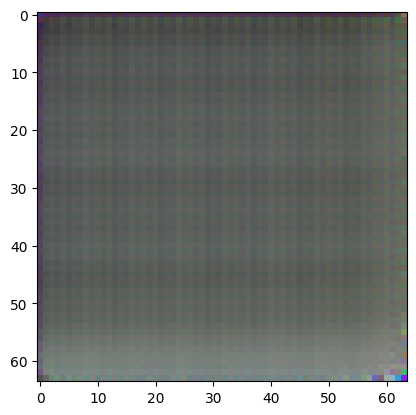

In [15]:
comet_final_image = im_negs_comet[-1][0].detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(comet_final_image)

# STats

In [10]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(clevr_gifs.flatten(), our_clevr_gifs.flatten())
print(f"T-statistic: {t_stat}, P-value: {p_value}, if p < 0.05, then the two images are significantly different.")

T-statistic: 1.4619983189066352, P-value: 0.14374209676298164, if p < 0.05, then the two images are significantly different.


In [11]:
# one sample t test, this is paired. 

from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(clevr_gifs.flatten(), our_clevr_gifs.flatten())
print(f"T-statistic: {t_stat}, P-value: {p_value}, if p < 0.05, then the two images are significantly different.")

T-statistic: 457.2792519501461, P-value: 0.0, if p < 0.05, then the two images are significantly different.


In [12]:
# mann whitney u test
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(clevr_gifs.flatten(), our_clevr_gifs.flatten())
print(f"U-statistic: {u_stat}, P-value: {p_value}, if p < 0.05, then the two images are significantly different.")

U-statistic: 68320513366.0, P-value: 4.486638176045221e-05, if p < 0.05, then the two images are significantly different.


# Compare EBM and EBM128

In [2]:
# now get our model:
import os
os.getcwd() 
os.chdir(os.pardir)
os.getcwd()

import matplotlib.pyplot as plt
import torch
from src.comet_models import LatentEBM, LatentEBM128
from src.config.load_config import load_config
from src.dataloader import MRI2D, Clevr
from imageio.v2 import get_writer
import logging
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from src.test_final import gen_image as gen_image_our


In [ ]:
def get_last_recon(checkpoint_path, model_type):
    config_path = '/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/config/2DMRI_config.yml'
    dataset_type = 'MRI2D'

    run_name = checkpoint_path.split("/")[-1].split(".")[0]
    logging.info(f"Run name: {run_name}")
    # Load configuration
    config = load_config(config_path)
    logging.info(f"Loaded config: {config}")

    run_name = checkpoint_path.split("/")[-1].split(".")[0]
    logging.info(f"Run name: {run_name}")

    dataset = MRI2D(config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    if model_type == "LatentEBM":
        model_class = LatentEBM
    elif model_type == "LatentEBM128":
        model_class = LatentEBM128
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dicts = checkpoint if isinstance(checkpoint, list) else [checkpoint]
    models = [model_class(config, dataset_type).to(device) for _ in range(len(state_dicts))]
    for i, model in enumerate(models):
        model.load_state_dict(state_dicts[i], strict=False)
        model.eval()  # Set to evaluation mode


    # Prepare data
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=config.data_workers)
    im, _ = next(iter(dataloader))
    im = im.to(device)

    # Embed latent
    latent = models[0].embed_latent(im)
    latents = torch.chunk(latent, config.components, dim=1)
    # each latent is a component, and has size (batch_size, latent_dim)

    im_neg = torch.rand_like(im)
    im_negs = gen_image_our(latents, config, models, im_neg, 30)

    our_final_image = im_negs[-1][0].detach().cpu().numpy().transpose(1, 2, 0)
    print(our_final_image.shape)

    return our_final_image



In [8]:
chekpomt= '/Users/carlahugod/Desktop/UNI/6sem/bach/energy-based-representation-learning/src/models/models_UN652_10100.pth'
modeltype = 'LatentEBM128'
our_final_image = get_last_recon(chekpomt, modeltype)

100%|██████████| 30/30 [36:55<00:00, 73.83s/it]   


(228, 198, 1)
